## Import libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, recall_score, precision_score, roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import pprint
pp = pprint.PrettyPrinter(indent=4)

## Importing data

In [3]:
loans = pd.read_csv("loan_approval_dataset.csv")
loans.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [5]:
loans.columns = loans.columns.str.strip() #some text had empty space

## Appendix graph, before CIBIL score is dropped

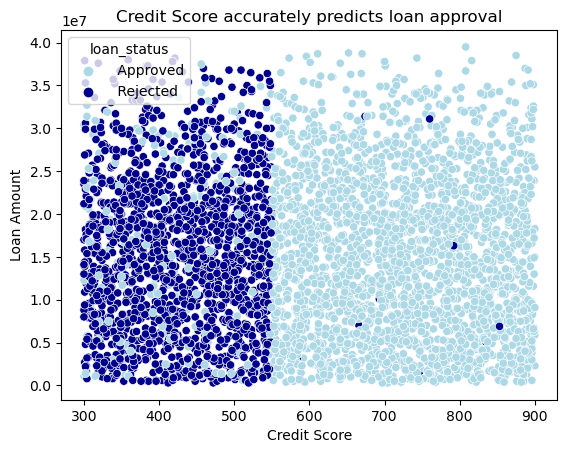

In [6]:
blue_palette = ["lightblue", "darkblue"]
sns.scatterplot(x=loans['cibil_score'], y= loans['loan_amount'], hue=loans['loan_status'],palette = blue_palette)
plt.title("Credit Score accurately predicts loan approval")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

## Cleaning

In [7]:
loans.drop("loan_id", axis=1, inplace=True)
loans.drop("cibil_score", axis=1, inplace=True) # Only consider 1st time applicants

loans['education'] = loans['education'].str.strip()
loans['self_employed'] = loans['self_employed'].str.strip()
loans['loan_status'] = loans['loan_status'].str.strip()

loans["education"] = loans["education"].replace({"Graduate" : 1, "Not Graduate" : 0})
loans["self_employed"] = loans["self_employed"].replace({"Yes" : 1, "No" : 0})
loans["loan_status"] = loans["loan_status"].replace({"Approved" : 1, "Rejected" : 0})

loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,12400000,8200000,29400000,5000000,0


## Data overview

In [8]:
loans.nunique()

no_of_dependents              6
education                     2
self_employed                 2
income_annum                 98
loan_amount                 378
loan_term                    10
residential_assets_value    278
commercial_assets_value     188
luxury_assets_value         379
bank_asset_value            146
loan_status                   2
dtype: int64

loan_status
1    2656
0    1613
Name: count, dtype: int64


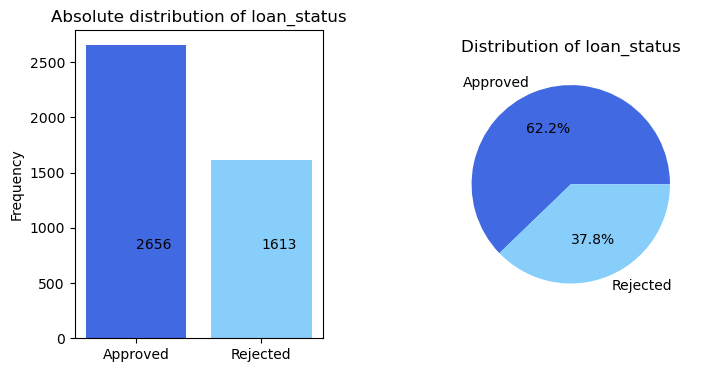

In [9]:
class_counts=loans["loan_status"].value_counts()
print(class_counts)

plt.figure(figsize=(8, 4))
           
plt.subplot(1,2,1)
plt.bar(["Approved", "Rejected"], class_counts, color = ["royalblue", "lightskyblue"])
plt.title("Absolute distribution of loan_status")
plt.ylabel("Frequency")
plt.text(["Approved"], class_counts[0]/2, class_counts[1])
plt.text(["Rejected"], class_counts[0]/2, class_counts[0])

plt.subplot(1,2,2)
plt.pie(class_counts, labels=["Approved", "Rejected"], autopct="%1.1f%%", colors= ["royalblue", "lightskyblue"])
plt.title("Distribution of loan_status")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Descriptive variable analysis

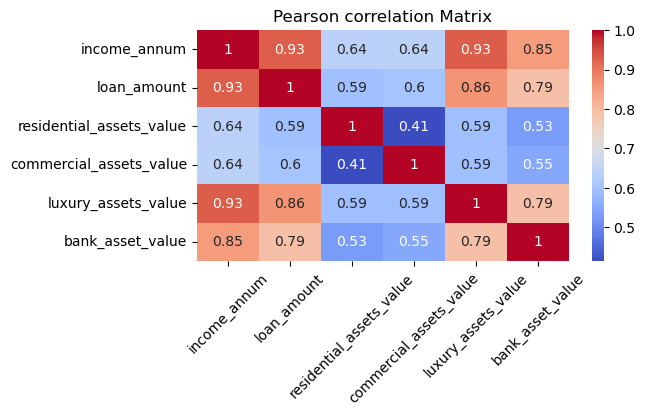

In [10]:
cont = loans[['income_annum', 'loan_amount', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']]
corr_matrix = cont.corr()

plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Pearson correlation Matrix')
plt.xticks(rotation=45)
plt.show()

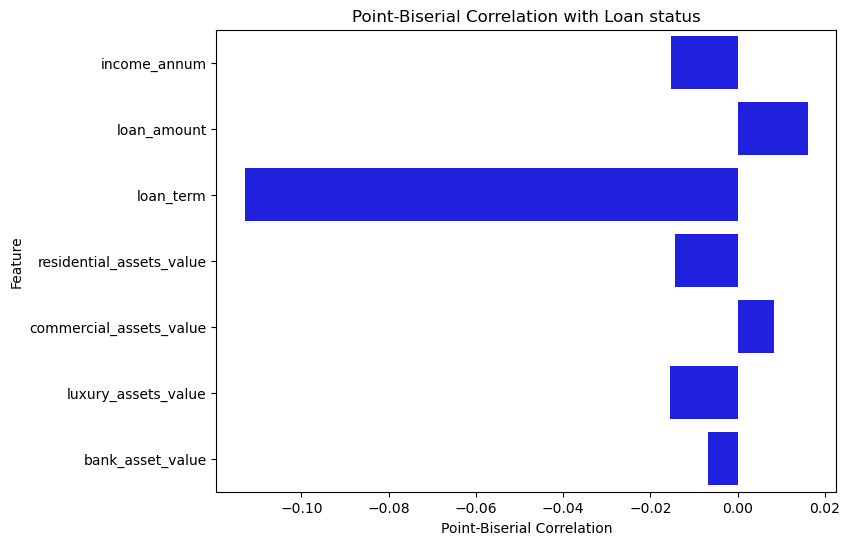

In [13]:
continuous_features = ['income_annum', 'loan_amount', 'loan_term', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
target_variable ='loan_status'

# Calculate Point-Biserial Correlation for each feature
correlations = {}
for feature in continuous_features:
    correlation, p_value = stats.pointbiserialr(loans[feature], loans[target_variable])
    correlations[feature] = correlation

correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Point-Biserial Correlation'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Point-Biserial Correlation', y='Feature', data=correlation_df, color='blue')
plt.title('Point-Biserial Correlation with Loan status')
plt.xlabel('Point-Biserial Correlation')
plt.ylabel('Feature')
plt.show()

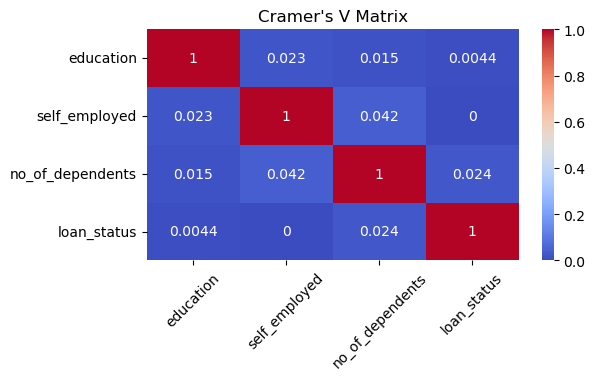

In [14]:
df = loans[['education', 'self_employed', 'no_of_dependents', 'loan_status']]

# create the contingency table matrix
def contingency_table_matrix(df):
    columns = df.columns
    matrix = np.zeros((len(columns), len(columns)))
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, _, _, _ = stats.chi2_contingency(contingency_table)
            min_categories = min(contingency_table.shape[0], contingency_table.shape[1])
            n = contingency_table.sum().sum()
            V = np.sqrt(chi2 / (n * (min_categories - 1)))
            matrix[i, j] = V
    return pd.DataFrame(matrix, columns=columns, index=columns)

# generate the Cramer's V coefficient matrix
cramers_v_matrix = contingency_table_matrix(df)

plt.figure(figsize=(6, 3))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm')

plt.title("Cramer's V Matrix")
plt.xticks(rotation=45)
plt.show()

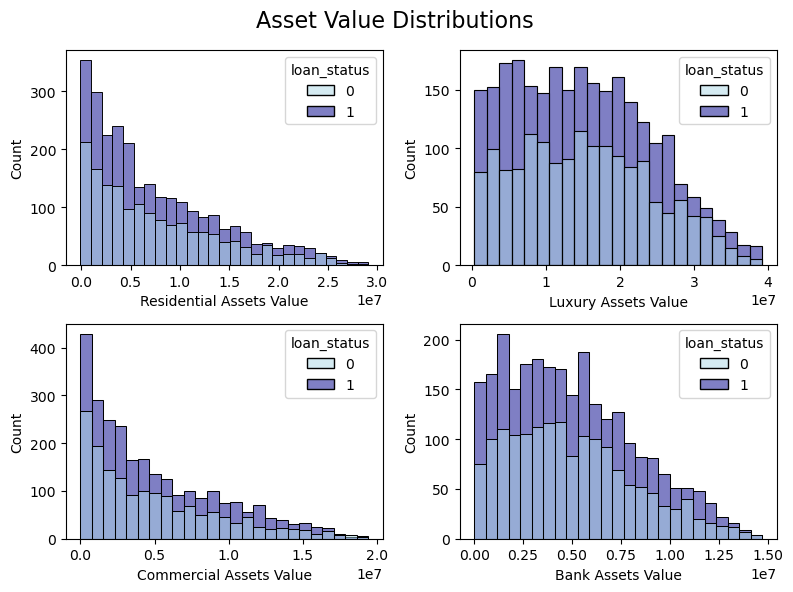

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

blue_palette = ["lightblue", "darkblue"]

sns.histplot(loans, x='residential_assets_value', hue='loan_status', palette=blue_palette, ax=axes[0, 0])
axes[0, 0].set_xlabel("Residential Assets Value")
axes[0, 0].set_ylabel("Count")


sns.histplot(loans, x='commercial_assets_value', hue='loan_status', palette=blue_palette, ax=axes[1, 0])
axes[1, 0].set_xlabel("Commercial Assets Value")
axes[1, 0].set_ylabel("Count")


sns.histplot(loans, x='luxury_assets_value', hue='loan_status', palette=blue_palette, ax=axes[0, 1])
axes[0, 1].set_xlabel("Luxury Assets Value")
axes[0, 1].set_ylabel("Count")


sns.histplot(loans, x='bank_asset_value', hue='loan_status', palette=blue_palette, ax=axes[1, 1])
axes[1, 1].set_xlabel("Bank Assets Value")
axes[1, 1].set_ylabel("Count")


plt.suptitle("Asset Value Distributions", fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipykernel_494/1054640245.py:5: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.histplot(loans, x='loan_term', hue='loan_status', palette=blue_palette, binwidth=1, discrete=True)


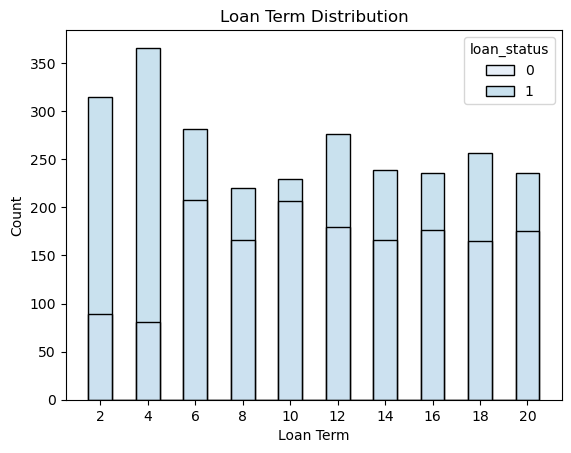

In [13]:
# Define a blue color palette with 4 different shades
blue_palette = sns.color_palette("Blues", 4)

# Create the histogram plot treating "loan_term" as a discrete variable
sns.histplot(loans, x='loan_term', hue='loan_status', palette=blue_palette, binwidth=1, discrete=True)

# Set plot title and labels
plt.title("Loan Term Distribution")
plt.xlabel("Loan Term")
plt.ylabel("Count")

# Customize the x-axis ticks
plt.xticks(range(2, 21, 2))

plt.show()